## Importing important libraries

In [21]:
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
import plotly.graph_objects as go
import tensorflow as tf

## Defining function&nbsp;to&nbsp;plot&nbsp;interactive&nbsp;plot

In [22]:
def interactive_plot(df,title):
    fig = px.line(title = title)
    for i in df.columns[1:]:
        fig.add_scatter(x = df['Date'], y = df[i],name = i)
    fig.show()

## Reading the stocks data for last 7 years

In [23]:
df = pd.read_csv('normalized_stocks.csv')

In [24]:
df.head()

,Date,FB,TWTR,NFLX
0,2013-11-07,1.000000,1.000000,1.000000
1,2013-11-08,0.999369,0.927617,1.024598
2,2013-11-11,0.971405,0.955457,1.033807
3,2013-11-12,0.980025,0.933185,1.021018
4,2013-11-13,1.024180,0.948775,1.025760


## Preparation to apply gradient descent

In [25]:
stocks = df.iloc[:,1:].to_numpy()
stocks = tf.constant(stocks,dtype=tf.float64)

In [26]:
W = np.random.random([3,1])
W = tf.math.abs(W)/tf.math.reduce_sum(tf.math.abs(W))
W = tf.Variable(W,dtype = tf.float64)

In [27]:
expected_value = tf.matmul(stocks,W)
daily_rate = (expected_value[1:] - expected_value[:-1])/expected_value[:-1]*100
sharpe_ratio = tf.math.reduce_mean(daily_rate)/tf.math.reduce_std(daily_rate)*np.sqrt(252)

In [28]:
sharpe_ratio

<tf.Tensor: shape=(), dtype=float64, numpy=1.0969872294134249>

In [29]:
with tf.GradientTape() as tape:
    expected_value = tf.matmul(stocks,W)
    daily_rate = (expected_value[1:] - expected_value[:-1])/expected_value[:-1]*100
    sharpe_ratio = tf.math.reduce_mean(daily_rate)/tf.math.reduce_std(daily_rate)*np.sqrt(252)

trainable_variables = [W]
grads = tape.gradient(sharpe_ratio, trainable_variables)
optimizer = tf.keras.optimizers.Adam(0.001)
optimizer.apply_gradients(zip(grads,trainable_variables))



<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

## Optimizing weights to give highest sharpe ratio

When we have highest sharpe ratio the risk associated with portfolio is minimum for the highest gain

Sharpe ratio after epoch 0: 1.096287
Sharpe ratio after epoch 100: 1.177552


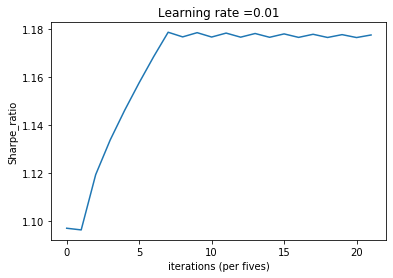

In [30]:
sharpe_ratios = [sharpe_ratio]
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate)
for epoch in range(101):
    with tf.GradientTape() as tape:
        W = tf.math.abs(W)/np.sum(tf.math.abs(W))
        W = tf.Variable(W,dtype = tf.float64)
        expected_value = tf.matmul(stocks,W)
        daily_rate = (expected_value[1:] - expected_value[:-1])/expected_value[:-1]*100
        sharpe_ratio = -tf.math.reduce_mean(daily_rate)/tf.math.reduce_std(daily_rate)*np.sqrt(252)

    trainable_variables = [W]
    grads = tape.gradient(sharpe_ratio, trainable_variables)
    optimizer.apply_gradients(zip(grads,trainable_variables))
    if epoch % 100 == 0:
        print ("Sharpe ratio after epoch %i: %f" % (epoch, -sharpe_ratio))
    if epoch % 5 == 0:
            sharpe_ratios.append(-sharpe_ratio)

    # Plot the cost
plt.plot(np.squeeze(sharpe_ratios))
plt.ylabel('Sharpe_ratio')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

In [31]:
tf.math.reduce_sum(tf.math.abs(W))
W = W.numpy()

In [32]:
df = pd.read_csv('normalized_stocks.csv')

In [33]:
W = np.abs(np.squeeze(W))

In [34]:
#investing 1 million
for i,column in enumerate(df.columns[1:]):
    df[column] = df[column]*W[i]*1000000
df ['Optimized portfolio daily worth in $'] = np.sum((df.iloc[:,1:]),axis=1)

## Plotting portfolio after optimization of the sharpe ratio

In [35]:
# Plot all stocks (normalized)
interactive_plot(df,'All Stocks')

In [36]:
df.to_csv('Optimized_investment.csv',index = False)

In [37]:
df = pd.read_csv('Optimized_investment.csv')

In [38]:
df.head()

,Date,FB,TWTR,NFLX,Optimized portfolio daily worth in $
0,2013-11-07,567492.794032,6446.613534,429163.049169,1.003102e+06
1,2013-11-08,567134.805839,5979.987853,439719.463557,1.012834e+06
2,2013-11-11,551265.077807,6159.459269,443671.564683,1.001096e+06
3,2013-11-12,556157.256963,6015.882136,438183.257849,1.000356e+06
4,2013-11-13,581214.736093,6116.385555,440218.410568,1.027550e+06


## Comparing with Random allocation

In [40]:
opt_inv = pd.read_csv('Optimized_investment.csv')
unopt_inv = pd.read_csv('unoptimized_investment.csv')
com_df = opt_inv.drop(['FB','TWTR','NFLX'],axis = 1)
com_df['Randomized portfolio daily worth in $'] = unopt_inv['portfolio daily worth in $']
interactive_plot(com_df,'Comaprision of Randomized and Optimized portfolio allocation')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a66acf1b-3c9e-4d67-a851-86f70092ac92' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>